In [2]:
%%capture
%cd ..

# Nth order Taylor method

$$
y_{i+1} = y_i + hT^{(N)}_i \Longrightarrow T^{(N)}_i = \sum_{n=0}^N \frac{h^n}{(n+1)!} f^{(n)}(t_i, y_i)
$$

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import display, HTML
from pathlib import Path
save_file = Path('data')/'Nth_Taylor.csv'

In [4]:
from threading import Thread, Condition
from queue import Queue
from dataclasses import dataclass
from typing import Callable
from math import factorial
import sympy as sp


def get_fs(f, m: int):
    t = sp.symbols('t')
    y = sp.Function('y')(t)
    dy = y.diff(t)
    f_sym = [f(t, y)]
    for _ in range(m):
        f_sym.append(f_sym[-1].diff(t).subs(dy, f_sym[0]))
    return [sp.lambdify((t, y), fs, 'numpy') for fs in f_sym]

@dataclass
class IVP:
    f:  Callable
    t0: float
    y0: float
    h:  float
    tf: float=np.inf

    @property
    def N(self) -> int: 
        return int(abs(self.tf - self.t0)/self.h)
    
    def __str__(self):
        t, y = sp.symbols('t, y')
        return r'$f(t, y) = {}$'.format(sp.latex(self.f(t, y)))

class Nth_Taylor:
    def __init__(self, ivp: IVP, m: int=1):
        self.h = ivp.h
        self._y = [ivp.y0]
        self._t = [ivp.t0]

        self.m = m
        self.fs = get_fs(ivp.f, m)

    def _T(self, n: int):
        return self.fs[n](self._t[-1], self._y[-1]) * self.h**n/factorial(n+1)
    
    @property
    def y(self):
        return np.stack(self._y)

    @property
    def t(self):
        return np.stack(self._t)
    
    def to_dataframe(self):
        return pd.DataFrame({
            't': self.t,
            'y':self.y
        })

    def reset(self):
        self._y = [self._y[0]]
        self._t = [self._t[0]]
    
    def step(self):
        self._y.append(self._y[-1] + self.h*sum(map(self._T, range(self.m))))
        self._t.append(self._t[-1] + self.h)
    
    def forward(self, steps: int=1):
        for _ in range(steps): self.step()

class Threaded_Nth_Taylor(Nth_Taylor):
    def __enter__(self):
        self.queue = Queue()
        self.condition = Condition()
        self.running = True
        self.threads = []
        for n in range(self.m):
            self.threads.append(Thread(target=self._task, args=(n, )))
            self.threads[-1].start()
        return self

    def __exit__(self, *args):
        self.running = False
        with self.condition: self.condition.notify_all()

    def _task(self, n: int):
        while self.running:
            with self.condition: self.condition.wait()
            self.queue.put(self._T(n))

    def step(self):
        with self.condition: self.condition.notify_all()
        T = 0
        for _ in range(self.m):
            T += self.queue.get()
        self._y.append(self._y[-1] + self.h*T)
        self._t.append(self._t[-1] + self.h)

## Testing

$$
f(t, y) = y - t^2 + 1, \quad y(0) = 0.5, \quad h=0.2
$$

In [4]:
problem = IVP(lambda t, y: y - t**2 + 1, t0=0, y0=0.5, h=0.2, tf=5)
solution = lambda t: -np.exp(t)/2 + t**2 + 2*t + 1

In [5]:
solver = Nth_Taylor(problem, m=2)
%time solver.forward(10)
result = solver.to_dataframe()
result['|y(ti) - yi|'] = abs(solution(result.t) - result.y)
display(HTML(result.to_html()))

CPU times: user 26 µs, sys: 11 µs, total: 37 µs
Wall time: 40.5 µs


,t,y,|y(ti) - yi|
0,0.0,0.500000,0.000000
1,0.2,0.830000,0.000701
2,0.4,1.215800,0.001712
3,0.6,1.652076,0.003135
4,0.8,2.132333,0.005103
5,1.0,2.648646,0.007787
6,1.2,3.191348,0.011406
7,1.4,3.748645,0.016245
8,1.6,4.306146,0.022663
9,1.8,4.846299,0.031122


In [6]:
with Threaded_Nth_Taylor(problem, m=2) as solver:
    %time solver.forward(10)
    display(HTML(solver.to_dataframe().to_html()))

CPU times: user 1.08 ms, sys: 466 µs, total: 1.54 ms
Wall time: 1.38 ms


,t,y
0,0.0,0.500000
1,0.2,0.830000
2,0.4,1.215800
3,0.6,1.652076
4,0.8,2.132333
5,1.0,2.648646
6,1.2,3.191348
7,1.4,3.748645
8,1.6,4.306146
9,1.8,4.846299


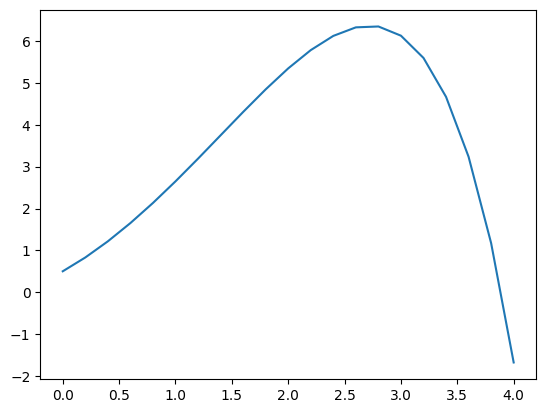

In [7]:
solver = Nth_Taylor(problem, m=2)
solver.forward(20)
plt.plot(solver.t, solver.y)

## Comparison between sequential and threaded algorithm

In [5]:
%%time

def timeit(function, *args, **kwargs):
    start = time.time()
    y = function(*args, **kwargs)
    stop = time.time()
    return stop-start, y

M = 10
problems = (
    IVP((lambda t, y: t*sp.exp(3*t) - 2*y), t0=0, y0=0, tf=10, h=0.5),
    IVP((lambda t, y: 1 + (t - y)**2), t0=2, y0=1, tf=10, h=0.5),
    IVP((lambda t, y: 1 + y/t), t0=1, y0=2, tf=10, h=0.5),
    IVP((lambda t, y: sp.cos(2*t) + sp.sin(3*t)), t0=0, y0=1, tf=10, h=0.5),
    IVP((lambda t, y: sp.exp(t - y)), t0=0, y0=1, tf=10, h=0.5),
    IVP((lambda t, y: (1 + t)/(1 + y)), t0=1, y0=1, tf=10, h=0.5),
    IVP((lambda t, y: -y + t*sp.sqrt(y)), t0=2, y0=1, tf=10, h=0.5),
    IVP((lambda t, y: t**(-2)*(sp.sin(2*t) - sp.sin(2*t*y))), t0=1, y0=1, tf=10, h=0.5)
)

columns = ('f', 't0', 'y0', 'tf', 'h', 'm', 'N', 'delay', 'solver')
df = []
for m in range(M):
    for ivp in problems:
        comum = (str(ivp), ivp.t0, ivp.y0, ivp.tf, ivp.h, m, ivp.N)

        solver = Nth_Taylor(ivp, m=m)
        delay, _ = timeit(solver.forward, ivp.N)
        df.append((*comum, delay, 'Nth_Taylor'))

        with Threaded_Nth_Taylor(ivp, m=m) as solver:
            delay, _ = timeit(solver.forward, ivp.N)
            df.append((*comum, delay, 'Threaded_Nth_Taylor'))
        
        pd.DataFrame(df, columns=columns).to_csv(save_file, index=False)

df = pd.DataFrame(df, columns=columns)
df.to_csv(save_file)
df.head()

CPU times: user 2min 39s, sys: 580 ms, total: 2min 40s
Wall time: 2min 40s


,f,t0,y0,tf,h,m,N,delay,solver
0,"$f(t, y) = t e^{3 t} - 2 y$",0,0,10,0.5,0,20,0.000014,Nth_Taylor
1,"$f(t, y) = t e^{3 t} - 2 y$",0,0,10,0.5,0,20,0.000023,Threaded_Nth_Taylor
2,"$f(t, y) = \left(t - y\right)^{2} + 1$",2,1,10,0.5,0,16,0.000008,Nth_Taylor
3,"$f(t, y) = \left(t - y\right)^{2} + 1$",2,1,10,0.5,0,16,0.000016,Threaded_Nth_Taylor
4,"$f(t, y) = 1 + \frac{y}{t}$",1,2,10,0.5,0,18,0.000009,Nth_Taylor


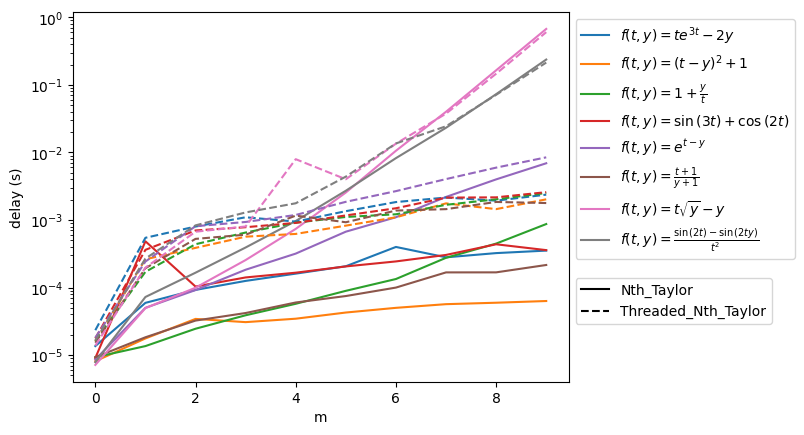

In [98]:
leg1 = []
leg2 = []
for solver_type, ls in zip(df.solver.unique(), ('-', '--')):
    line, = plt.plot([], [], f'k{ls}')
    leg1.append((line, solver_type))
    loc1 = df.solver == solver_type
    for i, f in enumerate(df.f.unique()):
        loc2 = df.f == f
        line, = plt.plot(df[loc1 & loc2].m, df[loc1 & loc2].delay, ls, c=f'C{i}')
        if ls == '-': leg2.append((line, f))
plt.semilogy()

plt.gca().add_artist(plt.legend(*np.stack(leg1).T, bbox_to_anchor=(1, 0.3)))
plt.legend(*np.stack(leg2).T, bbox_to_anchor=(1, 1))
plt.xlabel('m')
plt.ylabel('delay (s)')
plt.show()
# plt.semilogx()

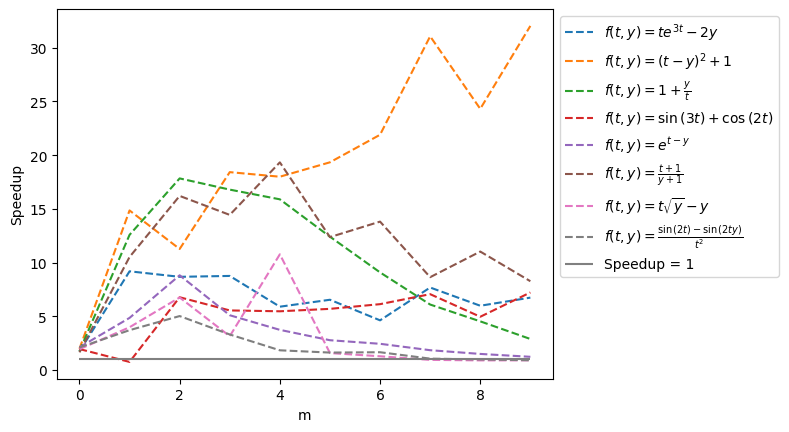

In [99]:
seq = df.solver == 'Nth_Taylor'
thr = df.solver == 'Threaded_Nth_Taylor'
for f in df.f.unique():
    loc = df.f == f
    plt.plot(df.m.unique(), df[thr & loc].delay.values/df[seq & loc].delay.values, '--', label=f)
plt.hlines(1, df.m.min(), df.m.max(), linestyles='-', color='gray', label='Speedup = 1')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('m')
plt.ylabel('Speedup')
plt.show()

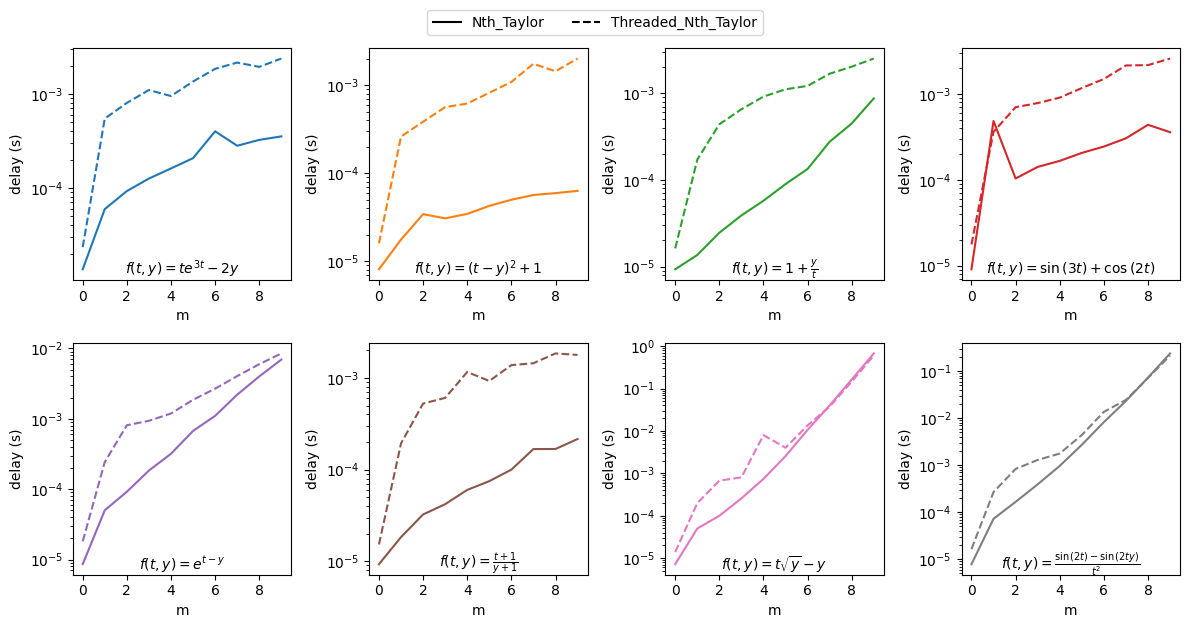

In [90]:
ax_width, ax_height = (3, 3)
cols = 4
rows = len(df.f.unique())//cols

fig, axs = plt.subplots(rows, cols, figsize=(ax_width*cols, ax_height*rows), )
axs = np.ravel(axs)

leg1 = []
leg2 = []
for solver_type, ls in zip(df.solver.unique(), ('-', '--')):
    line, = plt.plot([], [], f'k{ls}')
    leg1.append((line, solver_type))
    loc1 = df.solver == solver_type
    for i, f in enumerate(df.f.unique()):
        loc2 = df.f == f
        line, = axs[i].plot(df[loc1 & loc2].m, df[loc1 & loc2].delay, ls, c=f'C{i}')
        if ls == '-': 
            axs[i].text(df[loc1 & loc2].m.mean(), df[loc1 & loc2].delay.min(), f, ha='center', va='center')
            leg2.append((line, f))

for ax in axs: 
    ax.semilogy()
    ax.set_xlabel('m')
    ax.set_ylabel('delay (s)')

fig.legend(*np.stack(leg1).T, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncols=2)
# axs[-1].legend(*np.stack(leg2).T, bbox_to_anchor=(1, 1))

fig.tight_layout()
plt.show()